In [0]:
%run "./data_preprocessing"

'/Workspace/Users/hkarim@diez.ae/EDA workout/test workout'

### Visitor profile analysis 

### Exhibitor

In [0]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack
import matplotlib.pyplot as plt

In [0]:
visitors=pd.read_csv(r".\source\visitors.csv")
visitors_questions=pd.read_csv(r".\source\visitors_questions.csv")
visitors_answers=pd.read_csv(r".\source\visitors_answers.csv")


In [0]:
basedata,agg,agg2=process_visitor_data(visitors,visitors_questions,visitors_answers)

### EDA

In [0]:
basedata['gender'].value_counts()

gender
M    55
F    45
Name: count, dtype: int64

In [0]:
agg2.groupby('question_questions')['answer_answers'].value_counts()

question_questions                                                answer_answers                  
Please indicate your company's main area of business              Travel Agent                        54
                                                                  Tour Operator                       19
                                                                  Event management                     9
                                                                  IT solutions for travel industry     3
                                                                  Accommodation Provider               2
Reason for Attending the Event                                    To source products and services     35
                                                                  To obtain general information       24
                                                                  To promote products and services    20
                                                             

### Clustering analysis 

In [0]:
basedata_ml=basedata[['id','gender','Country','Region',"Please indicate your company's main area of business","Reason for Attending the Event","What is your company's annual purchasing budget?","What role do you play in the purchasing decision making process?",	"Which of the following best describes your job function?"]]

In [0]:
basedata_ml.fillna("",inplace=True)

/root/.ipykernel/3470/command-4720173271374049-3266983355:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basedata_ml.fillna("",inplace=True)


In [0]:
basedata_ml['text_combined']=basedata_ml["Please indicate your company's main area of business" ] + basedata_ml["Reason for Attending the Event"] + basedata_ml["What is your company's annual purchasing budget?"]+ basedata_ml["What role do you play in the purchasing decision making process?"] +basedata_ml["Which of the following best describes your job function?"]

In [0]:
# One-Hot Encode categorical columns
categorical_cols = ['gender', 'Country','Region']
ohe = OneHotEncoder(sparse=True, handle_unknown='ignore')
categorical_features = ohe.fit_transform(basedata_ml[categorical_cols])

In [0]:
# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
text_features = vectorizer.fit_transform(basedata_ml['text_combined'])

In [0]:
# Combine both categorical and text features
final_features = hstack([categorical_features, text_features])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0c1f01ad40>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_ca

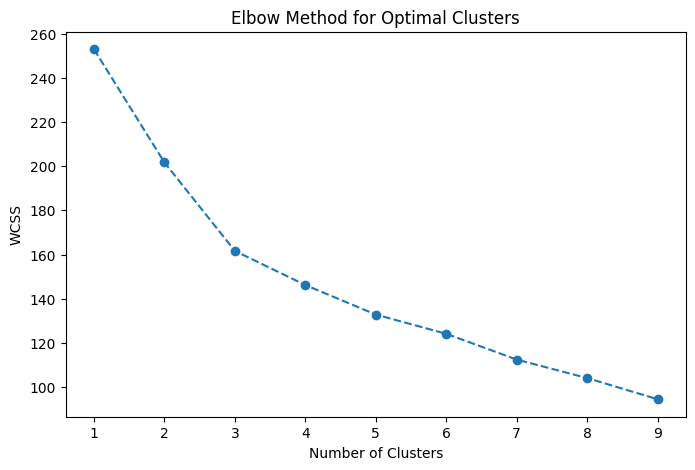

In [0]:
wcss = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(final_features)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [0]:
# Apply K-Means Clustering
num_clusters = 3 
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

In [0]:
basedata_ml['cluster'] = kmeans.fit_predict(final_features)

In [0]:
basedata_ml['cluster'].value_counts()

cluster
0    44
1    34
2    22
Name: count, dtype: int64

In [0]:
basedata_ml.groupby('cluster').agg({
  "gender":lambda x:x.value_counts().idxmax(),
  'Country':lambda x:x.value_counts().idxmax(),
  "Region":lambda x:x.value_counts().idxmax(),
  "Please indicate your company's main area of business":lambda x:x.value_counts().idxmax(),
  "Reason for Attending the Event":lambda x:x.value_counts().idxmax(),
  "What is your company's annual purchasing budget?":lambda x:x.value_counts().idxmax(),
  "What role do you play in the purchasing decision making process?":lambda x:x.value_counts().idxmax(),
  "Which of the following best describes your job function?":lambda x:x.value_counts().idxmax()

}).reset_index()

,cluster,gender,Country,Region,Please indicate your company's main area of business,Reason for Attending the Event,What is your company's annual purchasing budget?,What role do you play in the purchasing decision making process?,Which of the following best describes your job function?
0,0,M,Russia,Moscow,Travel Agent,To source products and services,,Advisory role,Visa support
1,1,F,Russia,Moscow,Travel Agent,To obtain general information,,No influence,
2,2,F,North Macedonia,,,Personal interest,,,
